Now that I have the data, it is time to train a model to learn how to create these tiers. As I am going through the fastai course (specifically the Tabular section), I will use the fastai library to train a neural network, as well as their recommended Random Forest approach to see which performs best. 

In [2]:
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc
import graphviz
import os
from dtreeviz.trees import *
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load CSV into Fastai Dataloaders and Train/Valid Splits

I will use FastAis dataloaders to easily load, normalize, and split the data for future training. 
I also export the train and valid datasets to try out with the Decision Trees/Random Forest approach.

In [143]:
df = pd.read_csv("rookie_year.csv")
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

I've decided to use the following categories: Completions, Attempts, Yards, Completion Percentage, Touchdowns, Interceptions, Yards/Game, and Sacks to feed the model. 

In [144]:
to = TabularPandas(df,
                 cont_names=["Cmp", "Att", "Yds", "Cmp%", "TD", "Int", "Y/G", "Sk"],
                 y_names="Tier",
                 procs=[FillMissing, Normalize],
                 splits=splits
                )

In [145]:
to.show()

,Cmp,Att,Yds,Cmp%,TD,Int,Y/G,Sk,Tier
239,47.0,98.0,530.0,48.000000,3.0,2.0,132.500000,18.0,Below-Average Career QB
293,255.0,476.0,2894.0,53.599998,11.0,22.0,192.899994,38.0,Below-Average Career QB
267,52.0,126.0,716.0,41.299999,8.0,13.0,89.500000,20.0,Below-Average Career QB
98,169.0,320.0,2074.0,52.799999,10.0,12.0,172.800003,28.0,Average Career QB
322,82.0,161.0,864.0,50.900002,4.0,9.0,123.400002,15.0,Below-Average Career QB
5,173.0,296.0,2210.0,58.400002,20.0,6.0,200.899994,10.0,Elite Career QB
40,158.0,328.0,2158.0,48.200001,19.0,16.0,154.100006,36.0,Above Average Career QB
11,87.0,194.0,1126.0,44.799999,6.0,13.0,112.599998,14.0,Elite Career QB
41,166.0,346.0,2183.0,48.000000,18.0,21.0,155.899994,47.0,Above Average Career QB
288,178.0,261.0,1694.0,68.199997,8.0,7.0,24.200001,26.0,Below-Average Career QB


In [6]:
dls = to.dataloaders(bs=64)

In [18]:
# Train Valid Split
xs,y = to.train.xs,to.train.y 
valid_xs,valid_y = to.valid.xs,to.valid.y

# Decision Trees/Random Forests

Fastai Recommends to at least try this approach first to see the performance since they are easier to work with, train, and understand than neural networks. 

In [19]:
# Helper functions for Tree Visualization
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

### Simple Decision Tree with 4 leaf nodes

In [20]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

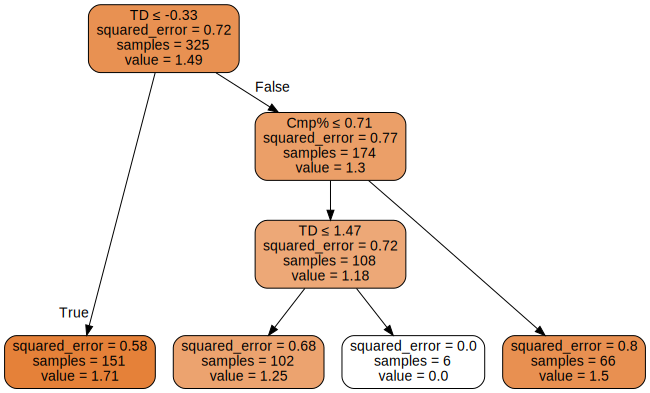

In [21]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

Similar Visualization, but with the datapoints

C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


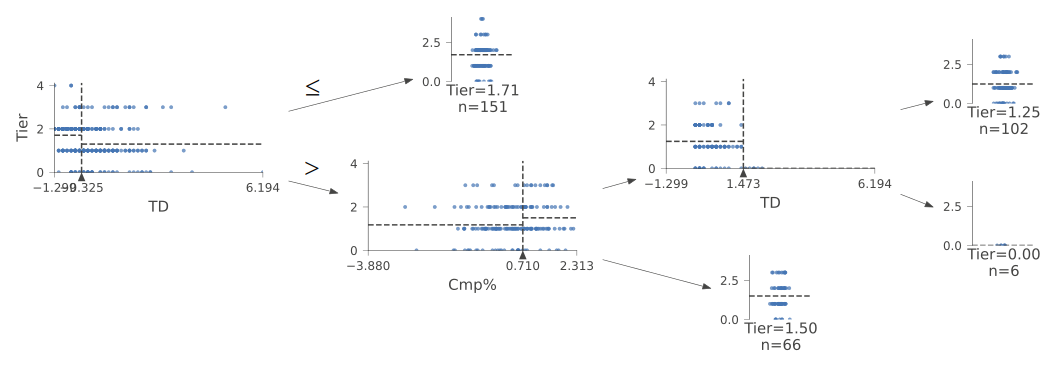

In [23]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, "Tier",
        fontname='DejaVu Sans', scale=2, label_fontsize=10,
        orientation='LR')

In [24]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [25]:
len(xs)

325

### Use arbitraly big Decision Tree

In [26]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [28]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.0, 1.300522)

Train Error is 0, but valid error is high (definition of overfitting). Here is why:

In [29]:
m.get_n_leaves(), len(xs)

(124, 325)

There are too many leaves compared to datapoints, need to have less so it can generalize more... Time for random forests to do this!

### Random Forests

Use the random forest approach with 40 "estimators" (random trees) which will be averaged (called bagging). 

In [88]:
def rf(xs, y, n_estimators=40, max_samples=len(xs),
       max_features=0.5, min_samples_leaf=5, **kwargs):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True)
    m.fit(xs, y)
    return m

In [89]:
m = rf(xs, y)

In [90]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.617003, 0.841323)

It looks like the error is much better. Now I will check how many estimators to use...

C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\skl

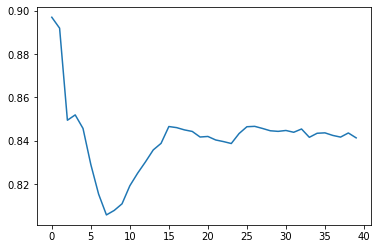

In [91]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

It looks like 40 estimators seems to give us some of the best performance. We can also look at the oob (out-of-bag) error. https://en.wikipedia.org/wiki/Out-of-bag_error

In [92]:
r_mse(m.oob_prediction_, y)

0.860368

This is a bit higher than the valid set, which makes sense. Now I will look at the predictions. I want to know how important each feature is in the dataset. Luckily there is this nice property (feature_importances_) that tells us just that

In [93]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [94]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
3,Cmp%,0.147414
4,TD,0.145543
0,Cmp,0.144447
2,Yds,0.143749
6,Y/G,0.120133
1,Att,0.114358
7,Sk,0.107574
5,Int,0.076782


Completion Percentage Seems to be the highest category followed by TD. Interestingly enough, interceptions are the lowest predictor. One thing to do is see if I can remove low-importance features. I'll use the cluster_columns function defined above which can tell us how closely connected two components are. 

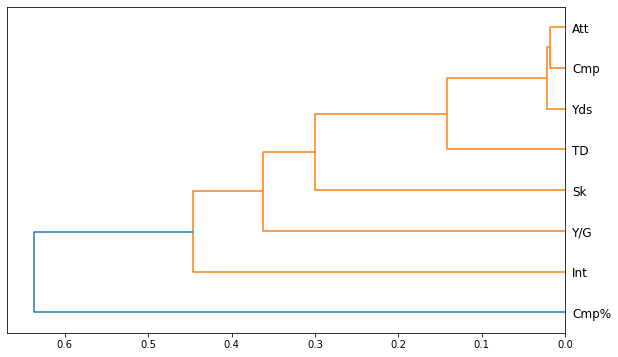

In [53]:
cluster_columns(xs)

It looks like Attempts and Completions are pretty similar (which makes sense) 

In [54]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=len(df), max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

I will check the difference of OOB Error between Completions and Attempts

In [68]:
get_oob(xs)

0.006721497139362986

In [77]:
{c:get_oob(xs.drop(c, axis=1)) for c in (
    'Cmp', 'Att')}

{'Cmp': 0.003757497556912348, 'Att': -0.000486470984402132}

I will drop the completions column and try the random forest again

In [79]:
xs_final = xs.drop(("Cmp"), axis=1)
valid_xs_final = valid_xs.drop(("Cmp"), axis=1)

But first, save the final dataset for future processing

In [107]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)

In [108]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')

In [109]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.628506, 0.869091)

I will also plot partial dependence on some of the best features. This will tell me how much each feature affects the overall score if all the other features were unchanged. 

C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


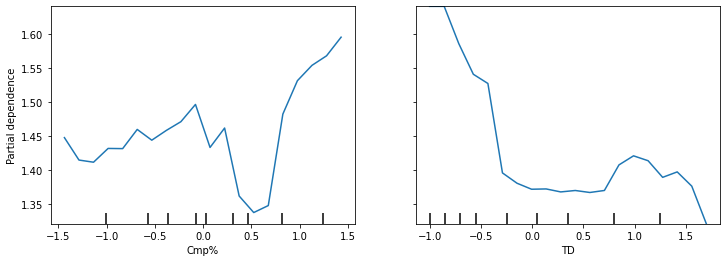

In [111]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['Cmp%','TD'],
                        grid_resolution=20, ax=ax);

Completion percentage looks good. The better the completion percentage, the better the overall score. However, TDs are a bit concerning. I will now use the treeinterpreter on a row to see how these predictions are made on an individual row. 

In [112]:
row = valid_xs_final.iloc[:5]

In [113]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [114]:
prediction[0], bias[0], contributions[0].sum()

(array([1.62246257]), 1.4856153846153846, 0.13684718549424438)

In [118]:
valid_xs_final.iloc[0]

Att     0.301647
Yds     0.442272
Cmp%    1.244385
TD     -0.550133
Int    -1.090999
Y/G     0.323963
Sk     -0.063729
Name: 81, dtype: float64

Lets's see which QB this is...

In [119]:
df.iloc[valid_xs_final.iloc[0].name]

Unnamed: 0                          5
Name                   Jeff Hostetler
Year                             1991
Age                                30
Tm                                0.0
Pos                               0.0
No.                              15.0
G                                  12
GS                               12.0
QBrec                             0.0
Cmp                               179
Att                               285
Cmp%                             62.8
Yds                              2032
TD                                  5
TD%                               1.8
Int                                 4
Int%                              1.4
1D                                0.0
Lng                                55
Y/A                               7.1
AY/A                              6.8
Y/C                              11.4
Y/G                             169.3
Rate                             84.1
QBR                               0.0
Sk          

C:\Users\matth\Anaconda3\envs\qb_preds\lib\site-packages\waterfall_chart.py:66: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  trans.loc[net_label]= total


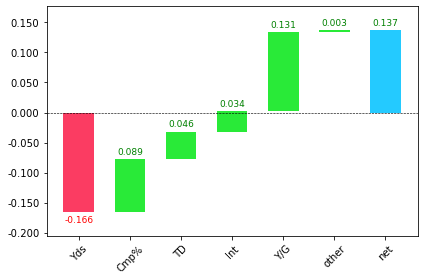

In [120]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This plot is a nice visualization of how much each factor affected the tier. One thing to look at is the confusion matrix, which helps visualize the accuracy of the predictions.

In [122]:
def create_confusion_matrix(m, xs, y):
    predictions = m.predict(xs).round()
    return confusion_matrix(y, predictions)
def plot_confusion(c):
    plt.figure(figsize=(15, 10))
    ax = sns.heatmap(c, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted QB Tier')
    ax.set_ylabel('Actual QB Tier');

    ## Ticket labels - List must be in alphabetical order
    labels = ['Elite','Above-Average', 'Average', "Below-Average", "Poor"]
    try:
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
    except ValueError:
        ax.xaxis.set_ticklabels(labels[:-1])
        ax.yaxis.set_ticklabels(labels[:-1])   
        

    ## Display the visualization of the Confusion Matrix.
    plt.show()    

In [123]:
cf1 = create_confusion_matrix(m, xs_final, y)
cf2 = create_confusion_matrix(m, valid_xs_final, valid_y)

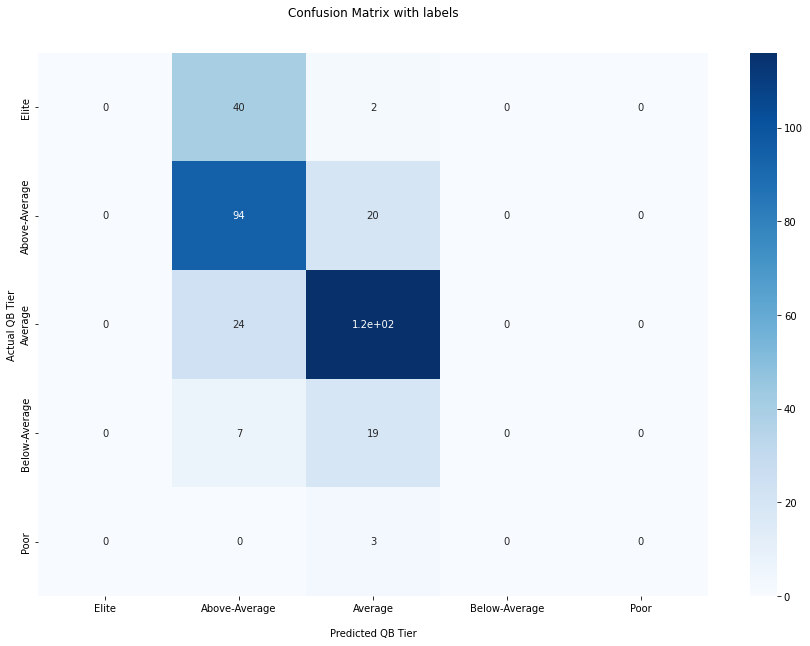

In [124]:
plot_confusion(cf1)

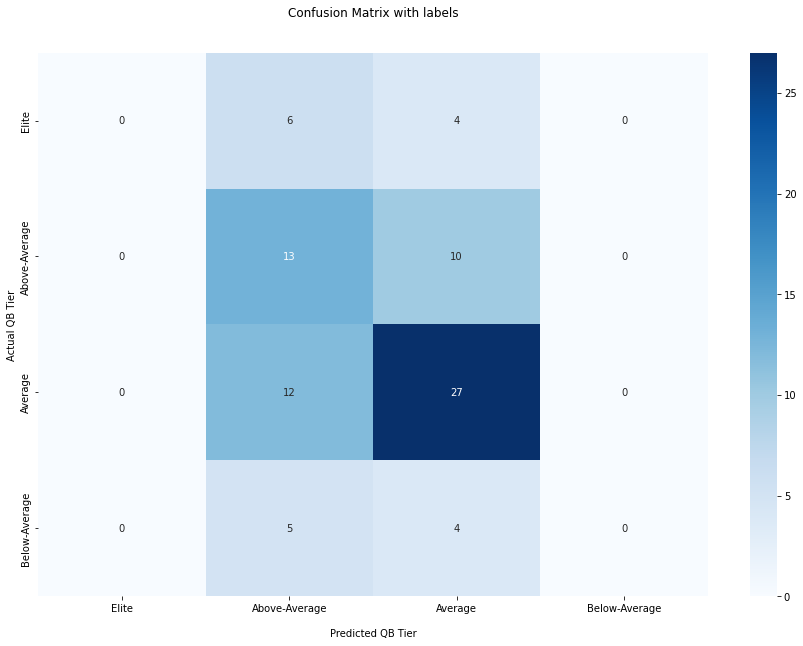

In [125]:
plot_confusion(cf2)

Very Interesting. It seems like the model only predicts a QB as Above-Average or Average (and gets resonable error). Maybe I should try neural networks. 

# Neural Networks (Tabular Learner from Fastai)

In [257]:
learn = tabular_learner(dls, metrics=accuracy, y_range=(0, 4))

SuggestedLRs(valley=0.009120108559727669)

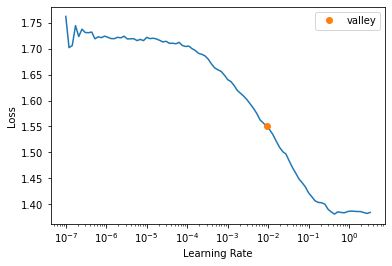

In [258]:
learn.lr_find()

In [259]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.701049,1.611899,0.148148,00:00
1,1.632857,1.575990,0.308642,00:00
2,1.562414,1.510631,0.419753,00:00
3,1.503722,1.455079,0.506173,00:00
4,1.455981,1.410133,0.543210,00:00
5,1.414858,1.371555,0.592593,00:00
6,1.386712,1.345630,0.604938,00:00
7,1.361518,1.331031,0.592593,00:00
8,1.339814,1.320998,0.604938,00:00
9,1.321386,1.315571,0.592593,00:00


It looks like I get pretty decent accuracy with only 10 epochs. 

In [260]:
learn.x

In [261]:
learn.show_results()

,Cmp,Att,Yds,Cmp%,TD,Int,Y/G,Sk,Tier,Tier_pred
0,-0.434394,-0.621348,-0.567919,1.188545,-0.561278,-0.298053,-0.318229,-0.470785,2.0,2.0
1,-0.757593,-0.924393,-1.081278,1.013416,-0.859586,-0.102756,-0.166273,-0.633125,2.0,2.0
2,-1.284287,-1.249611,-1.232084,-2.284843,-1.157894,-0.102756,-1.182258,-1.038975,2.0,2.0
3,-0.194987,0.154740,0.046666,-1.321635,0.184492,0.483135,-0.003715,-0.714295,2.0,1.0
4,1.744205,1.773439,1.736515,0.575594,0.482800,0.678432,0.971631,1.152612,0.0,1.0
5,0.020478,-0.222217,0.220195,1.480426,0.781108,-0.688647,1.943443,-0.714295,0.0,2.0
6,1.229481,1.477786,1.267571,-0.081139,0.333646,1.264323,0.469823,1.314952,1.0,1.0
7,0.666876,1.056481,0.689139,-0.694090,-0.262970,1.459620,0.211851,0.503253,2.0,1.0
8,-0.649860,-0.628740,-0.573084,-0.402209,-1.157894,0.287838,-0.966693,-0.714295,1.0,2.0


In [262]:
train_preds = learn.get_preds(dl=dls.train)[0]
valid_preds = learn.get_preds(dl=dls.valid)[0]

In [263]:
train_preds.shape

torch.Size([325, 5])

In [264]:
train_preds[0]

tensor([0.2934, 0.2642, 0.2279, 0.0816, 0.1330])

In [265]:
def create_confusion_matrix_fastai(xs, y):
    p = [np.argmax(r) for r in xs]
    return confusion_matrix(y, p)
    

In [266]:
cf1 = create_confusion_matrix_fastai(train_preds, y)
cf2 = create_confusion_matrix_fastai(valid_preds, valid_y)


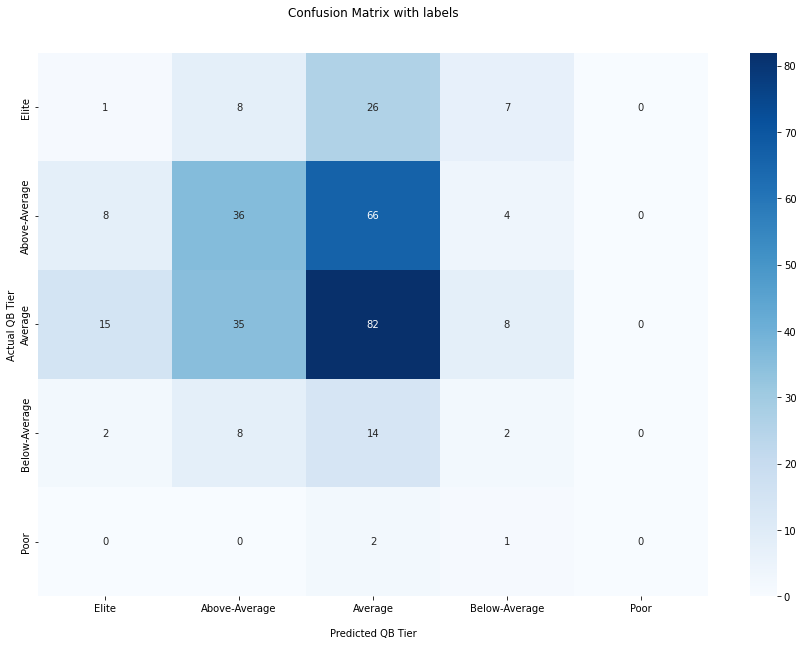

In [268]:
plot_confusion(cf1)

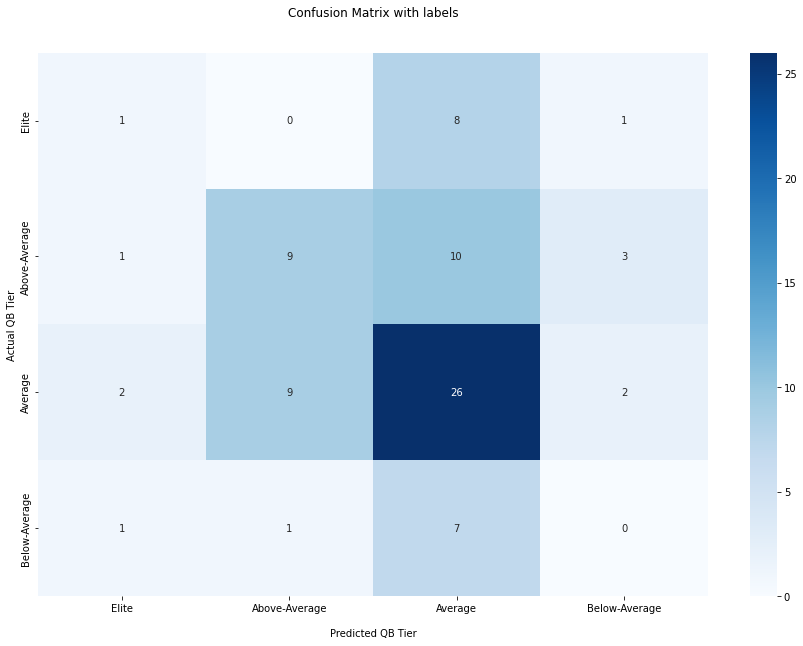

In [269]:
plot_confusion(cf2)

Unlike the random forests, this model actually predicts elite and below-average QBs! I will now look at the samples that the model has the most trouble with.

In [270]:
interp = Interpretation.from_learner(learn)

In [271]:
interp.top_losses(5)

(TensorBase([3.6675, 3.1234, 3.0624, 2.8671, 2.7010]),
 TensorBase([67, 31, 37,  3, 65]))

It looks like the model had some diffulty with Bernie Kosar, here are his rookie stats:

In [272]:
df.iloc[3]

Unnamed: 0                  2
Name            Philip Rivers
Year                        0
Age                        25
Tm                        0.0
Pos                       0.0
No.                      17.0
G                          16
GS                       16.0
QBrec                     0.0
Cmp                       284
Att                       460
Cmp%                     61.7
Yds                      3388
TD                         22
TD%                       4.8
Int                         9
Int%                      2.0
1D                      167.0
Lng                        57
Y/A                       7.4
AY/A                      7.4
Y/C                      11.9
Y/G                     211.8
Rate                     92.0
QBR                      67.4
Sk                         27
Yds.1                     144
Sk%                       5.5
NY/A                     6.66
ANY/A                    6.73
4QC                       4.0
GWD                       4.0
AV        

Of course I will check how it does on our original subject, Tom Brady

In [273]:
df[df["Name"] == "Tom Brady"].drop("Tier", axis=1).iloc[0]

Unnamed: 0            1
Name          Tom Brady
Year                  0
Age                  24
Tm                  0.0
Pos                 0.0
No.                12.0
G                    15
GS                 14.0
QBrec               0.0
Cmp                 264
Att                 413
Cmp%               63.9
Yds                2843
TD                   18
TD%                 4.4
Int                  12
Int%                2.9
1D                145.0
Lng                  91
Y/A                 6.9
AY/A                6.4
Y/C                10.8
Y/G               189.5
Rate               86.5
QBR                 0.0
Sk                   41
Yds.1               216
Sk%                 9.0
NY/A               5.79
ANY/A              5.39
4QC                 3.0
GWD                 3.0
AV                   12
Awards              0.0
Career_AV           316
Name: 0, dtype: object

In [328]:
row, clas, probs = learn.predict(df[df["Name"] == "Tom Brady"].iloc[0])

In [329]:
row.show()

,Cmp,Att,Yds,Cmp%,TD,Int,Y/G,Sk,Tier
0,264.000003,413.000006,2843.000036,63.9,18.0,12.0,189.5,41.0,Elite Career QB


Nice job model!